In this project, we will deal with _dimensionality reduction_ and learn how to develop a simple _Autoencoder_.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset seen in HW4.

In [ ]:
# import the usual libriaries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

np.random.seed(42)

### Load Dataset
We load the CIFAR-10 dataset, using `tf.keras.datasets`. The dataset contains 60,000 training images and 10,000 testing images.
The images are originally in RGB format, but we will convert them to grayscale for convenience. The value of each pixel is between 0 and 255, and it represents a point of an image of size 32 x 32. We will normalize all values between 0 and 1, and we will flatten the 32x32 images into vectors of size 1024.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [ ]:
cifar_10 = keras.datasets.cifar10
(X_train_full, _), (x_test, _) = cifar_10.load_data() # The dataset is already divede in test and training

X_train_full, x_test = np.mean(X_train_full, -1), np.mean(x_test, -1)

X_train_full = X_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

X_train_full = X_train_full.reshape((len(X_train_full), np.prod(X_train_full.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# We extract the first 10000 samples of the training set, to use them as the validation set
x_valid, x_train = X_train_full[:10000], X_train_full[10000:]

170508288/170498071 [==============================] - 3s 0us/step


## [TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Similar to Principal component analysis (PCA), Singular Value Decomposition (SVD) is a standard linear dimensionality reduction method. They both linealry combine the features of the original high-dimensional dataset and project them into a lower-dimensional space, ideally retaing most of thier intrinsic properties.

In this first part of the HW, we will focus our attention on SVD decomposition and its performances. Given a matrix $X$, the SVD decomposes it into the product of two unitary matrices $V$ and $U$ and a rectangular diagonal matrix of singular values $S$:

$$ X=V \cdot S \cdot U^T.$$

The SVD is already implemented in NumPy as `np.linalg.svd`. In our case, the $X$ matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features). However, notice that the $X$ matrix has a huge number of rows (we have 50,000 input samples) and only 784 columns. If you are using the _Colab_ free plan, the quantity of available RAM may not be sufficient to compute the SVD of $X$. Therefore, to ease memory consumption and numerical stability, we resort to one property of the SVD and compute its equivalent version from the covariance matrix $C= X^T \cdot X$, that can be decomposed as:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix $U$ to compute the compressed version of our data, this trick turns out to be a quick and good solution.

In [ ]:
def SVD(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k

Let's define the `ENCODING_DIM`, that will be the size of the compressed version of input data, and project the low-dimensional versions of the training set and the test set as well.

In [ ]:
ENCODING_DIM = 500

U_k = SVD(x_train, ENCODING_DIM)

x_training_svd = np.dot(x_train, U_k)
x_test_svd = np.dot(x_test, U_k)

We now reconstruct back the original input and check how much information was lost due to the compression. We do so by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco = np.dot(x_training_svd, U_k.T)
x_test_reco = np.dot(x_test_svd, U_k.T)

In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("Training mse: %.5f" % ( accuracy_train))
print("Test mse: %.5f" % ( accuracy_test))

Training mse: 0.00039
Test mse: 0.00041


In [ ]:
def plot_img(n, images_sets: list, title=""):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    for set_idx, images in enumerate(images_sets):
      ax = plt.subplot(len(images_sets), n, i + 1 + set_idx*n)
      plt.imshow(images[i].reshape(32, 32))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.suptitle(title)
  plt.show()

Let's see how well the input can be reconstructed by displaying a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of images corresponds to input data, while the second one contains the reconstructions.

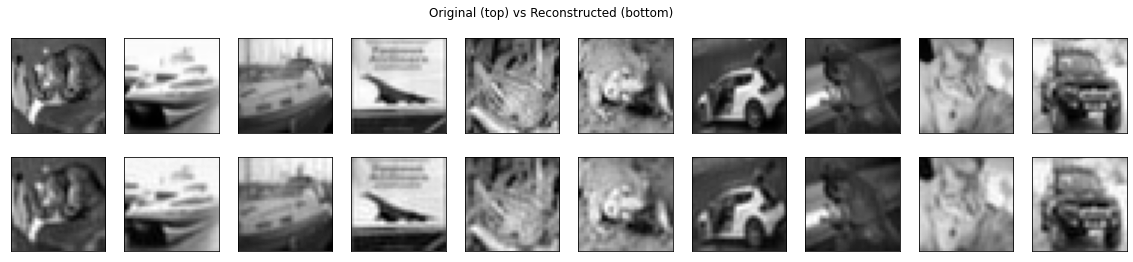

In [ ]:
plot_img(10, [x_test, x_test_reco], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]**: What happens by varying the `ENCODING_DIM`? Try it out and discuss the results in this cell.

_Answer:_
Increasing the encoding dimension increases the information in the compressed form.  So when the image is reconstructed, it looks almost the same as the original image, and vice versa. Decreasing the encoding dimension decreases the amount of information and therefore when reconstructed, the image becomes very blurry. The lower the dimension, the blurrier the image after reconstruction. This because the columns of vector U represent an orthogonal basis of all the column of vector X, therefore reducing the encoding dimension is basically reducing the dimensions of vector U.  

For example, when the Encoding Dimention is set to 12 then the reconstructed image is extremely blurry and cannot be recognised. Only broad information is retained like general areas of light (white) and general areas of darkness (black). It can be compared to an extremely low resolution image. This makes sense as decresing the encoding dimentionsality increases the MSE. Test mse: 0.00375 when encoding_dimensionality is set to 120 and Test mse: 0.00024 when encoding_dimnesionality is set to 600

However, decreasing the encoding dimentionality also decreases the runtime of the algorithm, and vice versa.


## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous HW when we used `Keras.Sequential()`, here we define the two parts of the model (encoder and decoder) separately and then we create the final model. 


In [ ]:
ENCODING_DIM = 500
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='linear')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_14 (Dense)            (None, 500)               512500    
                                                                 
 dense_15 (Dense)            (None, 1024)              513024    
                                                                 
Total params: 1,025,524
Trainable params: 1,025,524
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 6s 73ms/step - loss: 0.7315 - val_loss: 0.0373
Epoch 2/15
79/79 [==============================] - 6s 70ms/step - loss: 0.0311 - val_loss: 0.0264
Epoch 3/15
79/79 [==============================] - 5s 69ms/step - loss: 0.0232 - val_loss: 0.0209
Epoch 4/15
79/79 [==============================] - 7s 84ms/step - loss: 0.0189 - val_loss: 0.0174
Epoch 5/15
79/79 [==============================] - 6s 72ms/step - loss: 0.0160 - val_loss: 0.0150
Epoch 6/15
79/79 [==============================] - 6s 71ms/step - loss: 0.0140 - val_loss: 0.0133
Epoch 7/15
79/79 [==============================] - 5s 67ms/step - loss: 0.0124 - val_loss: 0.0118
Epoch 8/15
79/79 [==============================] - 5s 69ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 9/15
79/79 [==============================] - 7s 84ms/step - loss: 0.0112 - val_loss: 0.0097
Epoch 10/15
79/79 [==============================] - 5s 69ms/step - loss: 0.0093 - val_loss: 0.0089
Epoch 11/

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.grid()
  plt.title('loss')

313/313 - 1s - loss: 0.0062 - 1s/epoch - 4ms/step
Test mse: 0.00622


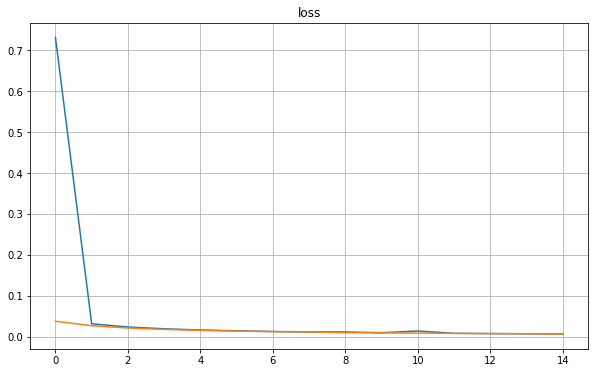

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

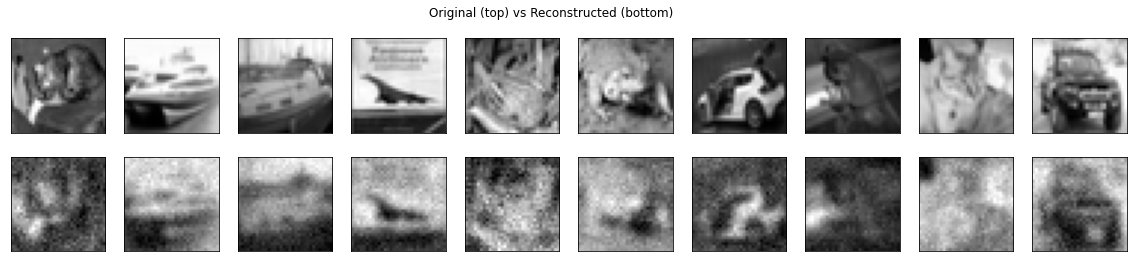

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

**[TO COMPLETE]** Check the results and compare them versus the results obtained with the SVD. Give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


_Answer:_

The shallow Linear Autoencoder (SLA) results are nosier than those of the SVD. the shallow Linear Autoencoded has a Test mse of 0.00599 when encoding_dimensionality is set to 120, which is more but comparable to the MSE of the SVD (0.00375). However, when the SLA is set to a encoding dimentionality of 600, its test MSE is Test mse: 0.00618. This is significantly higher to the SVD's test MSE of 0.00024. This shows that the SVD is able to encode the data much better than the the SLA, which is apparent when we do not constrain the SVD dimentionality and set it to more than 784, it returns a test MSe of 0, i.e. its able to fully encode the data but the SLA is unable to.

This is most likely due to the nature of the two. The SLA tries to learn features from the data and is unable to learn to them exactly, leading to slightly unprecise results. However, the SVD is able represent the data in its entirety if the encoding dimention is set to a large enough number to encompass all the columns of the data. This is less significant when comparing low encoding dimensionality as both of them give comparable results. It can also be noted that the SLA has longer runtimes than SVD and this is probably due to having to perform many gradient descents in the SLA.

##[TO COMPLETE] Exercise 5.3: Shallow Non-linear Autoencoders

**[TO COMPLETE]** Replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. 

Insert your code and theoretical discussion into cells immediately below this one.


In [ ]:
ENCODING_DIM = 600
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
# Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

# ...the decoder...
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)

# and the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

# Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_2 (Dense)             (None, 600)               615000    
                                                                 
 dense_3 (Dense)             (None, 1024)              615424    
                                                                 
Total params: 1,230,424
Trainable params: 1,230,424
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 7s 82ms/step - loss: 0.0402 - val_loss: 0.0256
Epoch 2/15
79/79 [==============================] - 6s 82ms/step - loss: 0.0213 - val_loss: 0.0190
Epoch 3/15
79/79 [==============================] - 6s 81ms/step - loss: 0.0165 - val_loss: 0.0337
Epoch 4/15
79/79 [==============================] - 6s 81ms/step - loss: 0.0171 - val_loss: 0.0127
Epoch 5/15
79/79 [==============================] - 6s 82ms/step - loss: 0.0134 - val_loss: 0.0119
Epoch 6/15
79/79 [==============================] - 6s 80ms/step - loss: 0.0127 - val_loss: 0.0164
Epoch 7/15
79/79 [==============================] - 6s 82ms/step - loss: 0.0112 - val_loss: 0.0099
Epoch 8/15
79/79 [==============================] - 6s 80ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 9/15
79/79 [==============================] - 7s 84ms/step - loss: 0.0091 - val_loss: 0.0086
Epoch 10/15
79/79 [==============================] - 7s 83ms/step - loss: 0.0085 - val_loss: 0.0110
Epoch 11/

313/313 - 1s - loss: 0.0064 - 1s/epoch - 4ms/step
Test mse: 0.00636


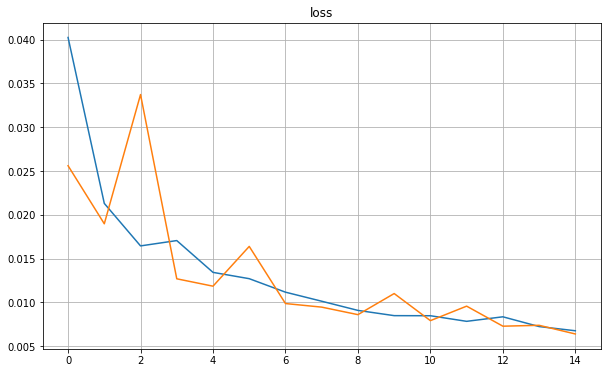

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

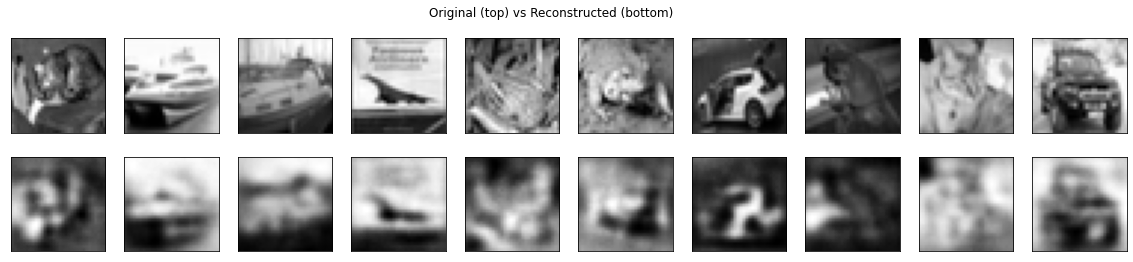

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

**ANSWER: **

For the non-linear activation function, the sigmoid function was chose because it has an output range from 0 to 1, which is similar to the input range in this autoencoder.

It was noted that that when the encoding dimensionality is set to 120, it has a Test mse of 0.00802. This is comparable but slightly more than both the SVD and SLA.

Encoding Dimensionality: (Test MSE)
- 50: 
  SVD: 0.00750
  SLA: 0.00833
  SNLA: 0.01158
- 120: 
  SVD:0.00375    
  SLA:0.00599    
  SNLA:0.00802
- 600: 
  SVD:0.00024   
  SLA:0.00618    
  SNLA:0.00619


From the results above, it can be seen that the sigmoid activation function performs much better at higher dimensionality than lower ones. This is contrasted when ReLu activation function is used on one of the layers instead of using sigmoid on both. ReLu performs better at lower dimensionality than on higher ones. This is most likely due to the fact that ReLU is linear in most of its range and therefore performs similar to the linear activation functions while sigmoid is more non-linear. 

The non-linearity of the sigmoid function most likely helps it with more complex functions and therefore better at learning higher dimensionality data. This is probably the resaon why the sigmoid function performs better than the SVD, and SLA.




##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]** Build a deep version of the Autoencoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and $n-1$ for decoding. The layers sizes of the encoding part decrease at each layer (e.g., `INPUT_DIM->128->64`, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (e.g., `128->INPUT_DIM`, the final overall structure recalls an hourglass ⏳).
As usual, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [ ]:
INPUT_DIM = x_train.shape[-1]
ENCODING_DIM = 64

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
#[TO COMPLETE]
encoded = tf.keras.layers.Dense(256, activation='sigmoid')(input_img)
encoded_2 = tf.keras.layers.Dense(128, activation='sigmoid')(encoded)
encoded_3 = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(encoded_2)

# ...the decoder...
decoded = tf.keras.layers.Dense(128, activation='sigmoid')(encoded_3)
decoded_2 = tf.keras.layers.Dense(256, activation='sigmoid')(decoded)
decoded_3 = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(decoded_2)




autoencoder = tf.keras.models.Model(input_img, decoded_3) #[TO COMPLETE]

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_38 (Dense)            (None, 256)               262400    
                                                                 
 dense_39 (Dense)            (None, 128)               32896     
                                                                 
 dense_40 (Dense)            (None, 64)                8256      
                                                                 
 dense_41 (Dense)            (None, 128)               8320      
                                                                 
 dense_42 (Dense)            (None, 256)               33024     
                                                                 
 dense_43 (Dense)            (None, 1024)              263

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs= 15, batch_size= 512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
79/79 [==============================] - 4s 49ms/step - loss: 0.0553 - val_loss: 0.0519
Epoch 2/15
79/79 [==============================] - 4s 47ms/step - loss: 0.0488 - val_loss: 0.0441
Epoch 3/15
79/79 [==============================] - 4s 48ms/step - loss: 0.0460 - val_loss: 0.0440
Epoch 4/15
79/79 [==============================] - 4s 46ms/step - loss: 0.0422 - val_loss: 0.0411
Epoch 5/15
79/79 [==============================] - 4s 48ms/step - loss: 0.0410 - val_loss: 0.0403
Epoch 6/15
79/79 [==============================] - 4s 48ms/step - loss: 0.0399 - val_loss: 0.0401
Epoch 7/15
79/79 [==============================] - 4s 50ms/step - loss: 0.0397 - val_loss: 0.0396
Epoch 8/15
79/79 [==============================] - 4s 49ms/step - loss: 0.0394 - val_loss: 0.0400
Epoch 9/15
79/79 [==============================] - 4s 49ms/step - loss: 0.0393 - val_loss: 0.0394
Epoch 10/15
79/79 [==============================] - 4s 48ms/step - loss: 0.0391 - val_loss: 0.0394
Epoch 11/

313/313 - 1s - loss: 0.0320 - 1s/epoch - 4ms/step
test mse: 0.03195


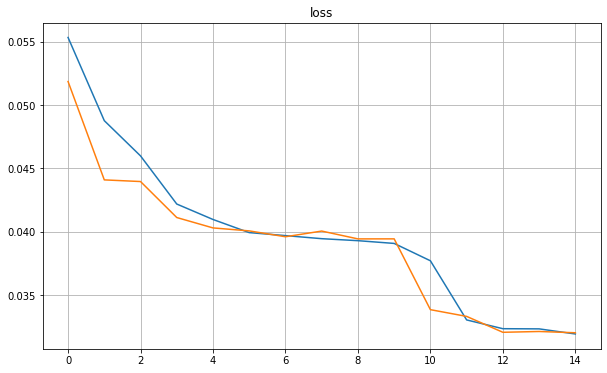

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

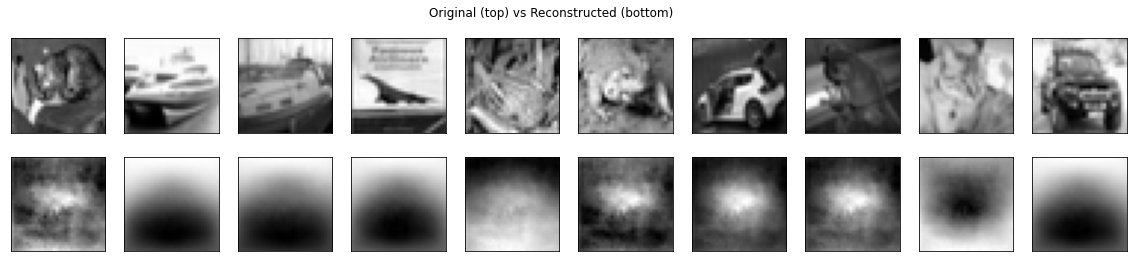

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, [x_test, decoded_imgs], title = "Original (top) vs Reconstructed (bottom)")

## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data. The idea is that only meaningful information will be encoded, thus filtering out useless noise.
Firstly, define a noisy input by adding some gaussian noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder.

In [ ]:
noise_factor = 0.3

x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)

# we still have to be sure that the color values are in the [0,1] range:
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs:

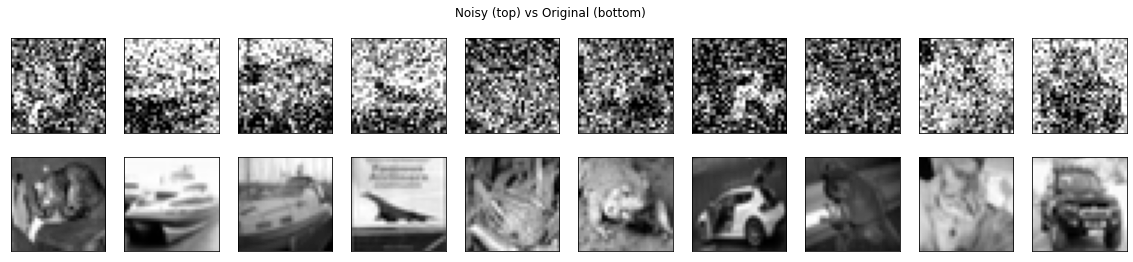

In [ ]:
plot_img(10, [x_test_noisy, x_test], title = "Noisy (top) vs Original (bottom)")

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (use a noise_factor $\geq 0.3$). 

In [ ]:
INPUT_DIM = x_train.shape[-1]

input_img = tf.keras.layers.Input(shape=(INPUT_DIM,))
#[TO COMPLETE]
encoded = tf.keras.layers.Dense(512, activation='sigmoid')(input_img)
decoded = tf.keras.layers.Dense(INPUT_DIM, activation='sigmoid')(encoded)
autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mse') #[TO COMPLETE]

In [ ]:
autoencoder.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_46 (Dense)            (None, 512)               524800    
                                                                 
 dense_47 (Dense)            (None, 1024)              525312    
                                                                 
Total params: 1,050,112
Trainable params: 1,050,112
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, epochs= 15, batch_size= 512, 
                          shuffle=True, validation_data=(x_valid_noisy, x_valid)) #[TO COMPLETE]

Epoch 1/15
79/79 [==============================] - 6s 74ms/step - loss: 0.0410 - val_loss: 0.0273
Epoch 2/15
79/79 [==============================] - 6s 70ms/step - loss: 0.0252 - val_loss: 0.0210
Epoch 3/15
79/79 [==============================] - 6s 71ms/step - loss: 0.0195 - val_loss: 0.0175
Epoch 4/15
79/79 [==============================] - 6s 71ms/step - loss: 0.0167 - val_loss: 0.0188
Epoch 5/15
79/79 [==============================] - 6s 72ms/step - loss: 0.0152 - val_loss: 0.0144
Epoch 6/15
79/79 [==============================] - 6s 71ms/step - loss: 0.0140 - val_loss: 0.0135
Epoch 7/15
79/79 [==============================] - 6s 72ms/step - loss: 0.0133 - val_loss: 0.0145
Epoch 8/15
79/79 [==============================] - 5s 68ms/step - loss: 0.0148 - val_loss: 0.0183
Epoch 9/15
79/79 [==============================] - 5s 70ms/step - loss: 0.0134 - val_loss: 0.0127
Epoch 10/15
79/79 [==============================] - 6s 73ms/step - loss: 0.0124 - val_loss: 0.0134
Epoch 11/

313/313 - 1s - loss: 0.0153 - 1s/epoch - 4ms/step
Test mse: 0.01530


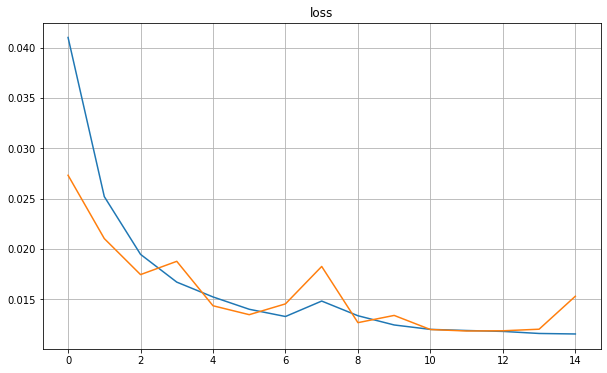

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("Test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

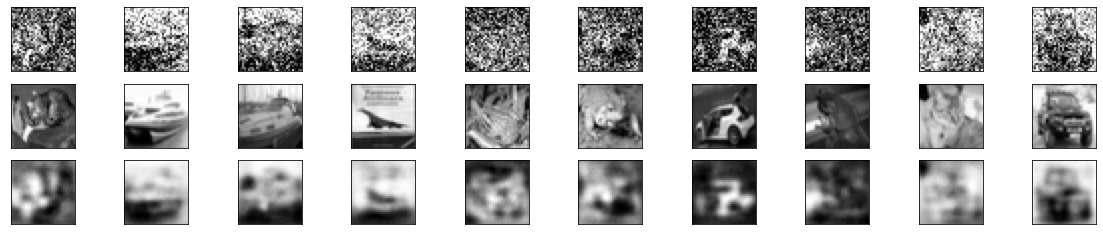

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, [x_test_noisy, x_test, decoded_imgs])

## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case we will use the IMDB dataset (already introduced in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in _Colab_), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [ ]:
from tensorflow.keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)

Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using `tf.keras.layers.SimpleRNN`. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 90, 50)            7550      
                                                                 
 time_distributed_2 (TimeDis  (None, 90, 100)          5100      
 tributed)                                                       
                                                                 
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 9s 97ms/step - loss: 0.1968 - categorical_accuracy: 0.0963 - val_loss: 0.0916 - val_categorical_accuracy: 0.3452
Epoch 2/50
79/79 [==============================] - 7s 92ms/step - loss: 0.0762 - categorical_accuracy: 0.4581 - val_loss: 0.0692 - val_categorical_accuracy: 0.5008
Epoch 3/50
79/79 [==============================] - 7s 93ms/step - loss: 0.0701 - categorical_accuracy: 0.4671 - val_loss: 0.0631 - val_categorical_accuracy: 0.5123
Epoch 4/50
79/79 [==============================] - 7s 94ms/step - loss: 0.0578 - categorical_accuracy: 0.5472 - val_loss: 0.0553 - val_categorical_accuracy: 0.5715
Epoch 5/50
79/79 [==============================] - 8s 97ms/step - loss: 0.0522 - categorical_accuracy: 0.5864 - val_loss: 0.0514 - val_categorical_accuracy: 0.5855
Epoch 6/50
79/79 [==============================] - 9s 115ms/step - loss: 0.0489 - categorical_accuracy: 0.6220 - val_loss: 0.0482 - val_categorical_accuracy: 0.6300
Epoch 7/5

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 1s - loss: 0.0079 - categorical_accuracy: 0.9598 - 529ms/epoch - 13ms/step
categorical_accuracy: 95.98%


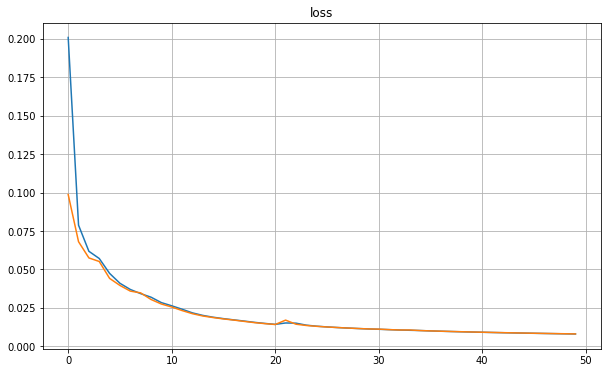

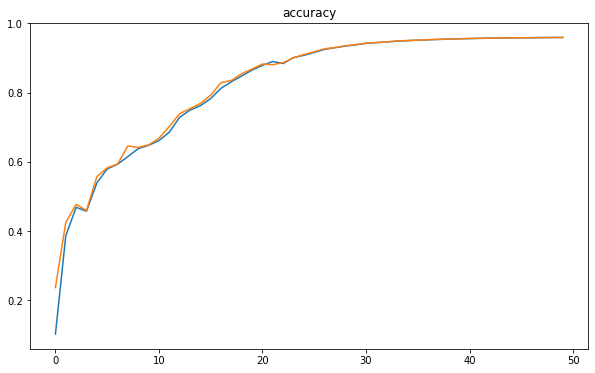

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
a a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just movie <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> and its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(50, activation='tanh', return_sequences=True)(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='sigmoid'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Model: "model_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 90, 100)]         0         
                                                                 
 lstm (LSTM)                 (None, 90, 50)            30200     
                                                                 
 time_distributed_3 (TimeDis  (None, 90, 100)          5100      
 tributed)                                                       
                                                                 
Total params: 35,300
Trainable params: 35,300
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 [==============================] - 15s 158ms/step - loss: 0.3033 - categorical_accuracy: 0.3127 - val_loss: 0.0768 - val_categorical_accuracy: 0.4614
Epoch 2/50
79/79 [==============================] - 12s 149ms/step - loss: 0.0622 - c

40/40 - 1s - loss: 0.0053 - categorical_accuracy: 0.9795 - 515ms/epoch - 13ms/step
categorical_accuracy: 97.95%


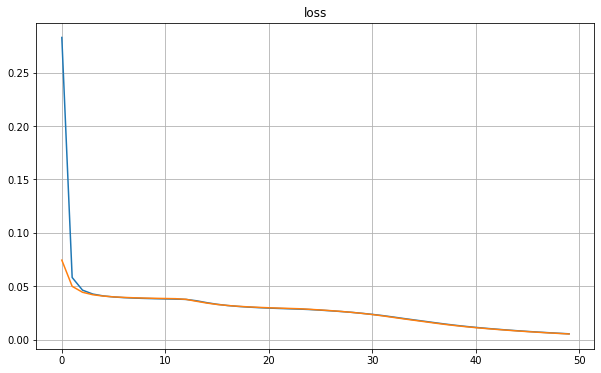

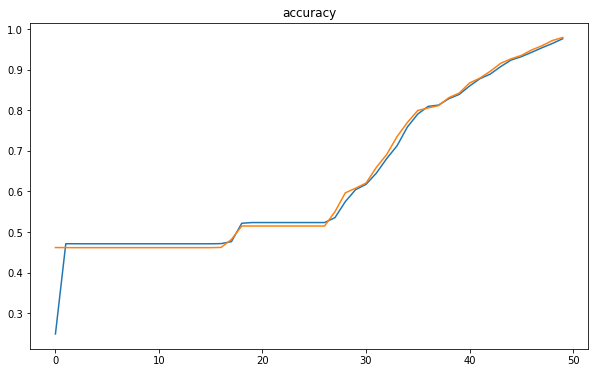

In [ ]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really time film that <oov> <oov> <oov> than is <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


**ANSWER:**

  The choice of the activation function is dependent on the type of problem that is being solved; regression or classification.

  Here, the probelm is a binary classification problem that requires the prediction to be either 0 or 1 because of the one-hot encoding of the data, i.e. the outcomes of the model (classes) are mutually exclusive. Therefore, for a binary classification problem the appropriate output activation function to use is the sigmoid function because the sigmoid activation function can take any real value as input and gives values in the range of 0 to 1 as outputs. 

  The more positive (larger) the input value is, the closer it will be to 1, and vice versa for negative values. 

  The activation function of the hidden layer was changed and experimented with to see which one produces the best result. Tanh on the hidden layer performed the best, with an accuracy of 98.10%, compared to relu and sigmoid on the hidden layer with 95.4% and 59% respectively. This is probably due to the fact that tanh converges faster than the rest.

  For loss function: objective is to minimize the loss function. And we do this by penalising the probabilities that are predicted by the model based on how far or close it is to the actual value. Since this is a binary classification problem, the most appropriate loss function to use is the binary crossentropy. It calculates the negative average of the log of the corrected predicted probabilities. 


  When comparing the Linear autoencoder for sequences with the Non-linear Autoencoder for sequences, it can be seen that non-linear one performs slightly better with a categorical accuracy of 98.10% compared to 94.84%. This difference in accuracy can be attributed to 2 aspects: the non-linaer activation function and the LSTM layer. It is difficult to say what contributes more to the improvement in accuracy. And therefore, a test was carried out by only changing the activation function to non-linear but keeping the SimpleRNN layer. This demonstrated the effect of only the non-linear activation function on the results. The model produced a categorical accuracy of 98.02%, which extremely close to the accuracy of the model with non-linear activation function + LSTM layer. 


  Therefore, it can be concluded that the majority of the improvement in the Non-Linear Autoencoded for sequences comes from the non-linear activation function. In general it can be seen that introducing non-linearity in the models allows the model to learn more complex features and therefore perform better. 